In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import argparse
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
import torch
from torch import nn
import torch.optim.adam
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [ ]:
class simple_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5760, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Dropout(0.5),
            
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        # self.linear_relu_stack.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class from_evo(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3840, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        # self.linear_relu_stack.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class small_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3840, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),

            nn.Linear(512, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        # self.linear_relu_stack.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class mini_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3840, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            # nn.Dropout(0.3),

            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        # self.linear_relu_stack.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [4]:
def train_model(model, epochs, train_dataloader, test_dataloader, checkpoint_path, loss_fn= nn.BCELoss(), optimizer = torch.optim.Adam, device = "cuda:0", verbose=False):
    
    model = model().to(device)
    optimizer = optimizer(model.parameters(), lr=0.0001)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=20, min_lr=1e6)

    best_acc = 0
    best_loss = 9999999999
    history = []
    best_epoch = 0
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_a, train_l = run_train(train_dataloader, model, loss_fn, optimizer, device, verbose)
        test_acc, test_l = run_test(test_dataloader, model, loss_fn, device)
        scheduler.step(test_l)
        history.append({"epoch":t, "accuracy": train_a, "loss": train_l, "phase": "train"})
        history.append({"epoch":t, "accuracy": test_acc, "loss": test_l, "phase": "test"})
        if test_l < best_loss:
            print(f"new high! {test_l}")
            torch.save(model.state_dict(), checkpoint_path)
            best_loss = test_l
            best_epoch = t
        
        print(f"Epoch: {t}, train a/l: {train_a:>0.3f}/{train_l:>0.3f} test a/l: {test_acc:>0.3f}/{test_l:>0.3f}")
    print(f"Best acc: {best_acc}, best epoch: {best_epoch}")

    print("Done!")
    return model, history


def run_train(dataloader, model, loss_fn, optimizer, device, v):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    total_accuracy, total_loss = 0, 0
    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)
        if v: print(f"shape X : {X.shape}")
        if v: print(f"X : {X}")

        if v:print(f"shape y : {y.shape}")
        if v:print(f"y : {y.tolist()}")

        pred = model(X)

        if v:print(f"shape pred: {pred.shape}")
        if v:print(f"pred: {pred}")
        if v:print(f"pred round: {pred.round().tolist()}")
        if v:print(f"pred accuracy: {(pred.round() == y).tolist()}")

        # Should I add round here aswell ?
        loss = loss_fn(pred, y)
        if v:print(f"loss: {loss.tolist()}")
        # print(loss.shape)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss +=  loss.item()
        # print(pred)
        
        total_accuracy += (pred.round() == y).type(torch.float).sum().item()
        
        # if batch % 20 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     accuracy = (pred.round() == y).type(torch.float).sum().item() / size
        #     print(f"loss: {loss:>7f}, accuracy:{100*accuracy:>0.1f}  [{current:>5d}/{size:>5d}]")

    total_loss /= num_batches
    total_accuracy /= size
    return total_accuracy, total_loss

def run_test(dataloader, model, loss_fn, device):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
    
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.round() == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

def run_validation(model, dataloader,  loss_fn= nn.BCELoss(), device = "cuda:0"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    prediction = []
    labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
    
            pred = model(X)
            prediction.extend(pred.cpu())
            labels.extend(y.cpu())

            test_loss += loss_fn(pred, y).item()
            correct += (pred.round() == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"validation Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return prediction, labels
    
def plot_auc(preds, labels, out, title=""):
    viz = RocCurveDisplay.from_predictions(labels, preds, pos_label=True)
    viz.ax_.set_title(title)
    viz.plot()
    plt.savefig(str(out)+"auc_val.png", dpi=300, bbox_inches="tight")

def plot_history(hist, out, title=""):
    df = pd.DataFrame(hist)
    plt.figure()
    lp = sns.lineplot(data=df, x="epoch", y="accuracy", hue="phase")
    lp.set_title(title)
    lp.figure.savefig(str(out)+"_accuracy.png")
    
    plt.figure()
    lp = sns.lineplot(data=df, x="epoch", y="loss", hue="phase")
    lp.set_title(title)
    lp.figure.savefig(str(out)+"_loss.png")

def make_dataloaders_old(input, batch_size, sample=None, name="", v=False):
    df = pd.read_csv(input, sep="\t", header=0, index_col=0)
    print(df.shape)
    if name:
        df1 = df.query('similar == False').sample(n=int(sample/2), random_state=42)
        df2 = df.query('similar == True').sample(n=int(sample/2), random_state=42)
        df = pd.concat([df1, df2])
        df.to_csv(name, sep="\t")
    
    df.em_x = df.em_x.apply(eval)
    df.em_y = df.em_y.apply(eval)

    samples = df.em_x + df.em_y
    x = np.array(samples.values.tolist())
    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)
    y = df.similar.astype(int).values   

    if v: print(f"len x : {len(x)}")
    if v: print(f"x : {x}")
    if v: print(f"len y : {len(y)}")
    if v: print(f"y : {y}")
    dl = DataLoader(
        TensorDataset(
            torch.tensor(x_scaled, dtype=torch.float32), 
            torch.tensor(y, dtype=torch.float32).unsqueeze(1)
            ), 
        batch_size=batch_size, shuffle=True
        )
    
    return dl

def make_dataloaders(embeddings, batch_size, df = None, input_path = "", sample=None, name="", v=False, compression=False):
    if input_path != "":
        df = pd.read_csv(input_path, sep="\t", header=0, index_col=0)
    else:
        df = df
    if compression:
        em = pd.read_csv(embeddings, sep="\t", header=0, index_col=0, compression="gzip")
    else:
        em = pd.read_csv(embeddings, sep="\t", header=0, index_col=0)

    em.embedding = em.embedding.apply(eval)
    
    # if name:
    #     df1 = df.query('similar == False').sample(n=int(sample/2), random_state=42)
    #     df2 = df.query('similar == True').sample(n=int(sample/2), random_state=42)
    #     df = pd.concat([df1, df2])
    #     df.to_csv(name, sep="\t")

    df = df.merge(em,
                    left_on="segment_id_x",
                    right_on="segment_id",
                    ).drop(columns=['segment_id']).rename({"embedding":"em_x"}, axis=1)
    df = df.merge(em,
                    left_on="segment_id_y",
                    right_on="segment_id",
                    ).drop(columns=['segment_id']).rename({"embedding":"em_y"}, axis=1)

    # display(df.head())
    samples = df.em_x + df.em_y
    samples = np.array(samples.values.tolist())
    

    scaler = StandardScaler()
    scaler.fit(samples)
    x_scaled = scaler.transform(samples)
    y = df.similar.astype(int).values   

    if v: print(f"len x : {len(x_scaled)}")
    if v: print(f"x : {x_scaled[0]}")
    if v: print(f"len y : {len(y)}")
    if v: print(f"y : {y[0]}")
    dl = DataLoader(
        TensorDataset(
            torch.tensor(x_scaled, dtype=torch.float32), 
            torch.tensor(y, dtype=torch.float32).unsqueeze(1)
            ), 
        batch_size=batch_size, shuffle=True
        )
    
    return dl

In [3]:
embeddings_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_embeddings.tsv")
df = pd.read_csv(embeddings_path, sep="\t", header=0)
df.shape

(2646, 3)

In [ ]:
model_str = "simple"
train_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_train_old.tsv")
test_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_test_old.tsv")
val_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_val_old.tsv")
# embeddings_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_embeddings.tsv")
output_prefix = Path(f"results/testing/sm7_500000_old{model_str}_")
checkpoint_path = Path(f"saved_models/sm7_500000_old{model_str}_")
batch_size = 128
epochs = 500
validation = True
device = "cpu"


model_names = {"simple": simple_network,
               "small": small_network,
               "mini": mini_network}
if model_str in model_names:
    model = model_names[model_str]
else: raise ValueError(f"cannot find model with name {model_str}")

print("Making train loader")
train_loader = make_dataloaders_old(train_path, batch_size)

print("Making test loader")
test_loader = make_dataloaders_old(test_path, batch_size)

model, history = train_model(model, epochs, train_loader, test_loader, checkpoint_path=checkpoint_path, verbose=False, device=device)
plot_history(history, output_prefix)

model = model_names[model_str]

model = model().to("cpu")
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model.eval()

if validation:
    print("Making val loader")
    val_loader = make_dataloaders_old(val_path, batch_size)
    pred, labels = run_validation(model, val_loader, device=device)
    plot_auc(pred, labels, output_prefix)

Making train loader
Making test loader
new high! 0.7775343656539917
Epoch: 0, train a/l: 0.496/1.082 test a/l: 0.515/0.778
new high! 0.756266454855601
Epoch: 1, train a/l: 0.556/0.730 test a/l: 0.561/0.756
new high! 0.7033222913742065
Epoch: 2, train a/l: 0.570/0.685 test a/l: 0.536/0.703
Epoch: 3, train a/l: 0.607/0.661 test a/l: 0.512/0.705
new high! 0.6990783015886942
Epoch: 4, train a/l: 0.609/0.656 test a/l: 0.518/0.699
Epoch: 5, train a/l: 0.617/0.646 test a/l: 0.544/0.715
Epoch: 6, train a/l: 0.619/0.638 test a/l: 0.534/0.708
Epoch: 7, train a/l: 0.629/0.645 test a/l: 0.482/0.732
Epoch: 8, train a/l: 0.619/0.642 test a/l: 0.571/0.717
Epoch: 9, train a/l: 0.636/0.631 test a/l: 0.518/0.715
Epoch: 10, train a/l: 0.637/0.625 test a/l: 0.507/0.727
Epoch: 11, train a/l: 0.655/0.625 test a/l: 0.501/0.734
Epoch: 12, train a/l: 0.636/0.636 test a/l: 0.534/0.712
Epoch: 13, train a/l: 0.650/0.624 test a/l: 0.515/0.724
Epoch: 14, train a/l: 0.657/0.617 test a/l: 0.534/0.726
Epoch: 15, train

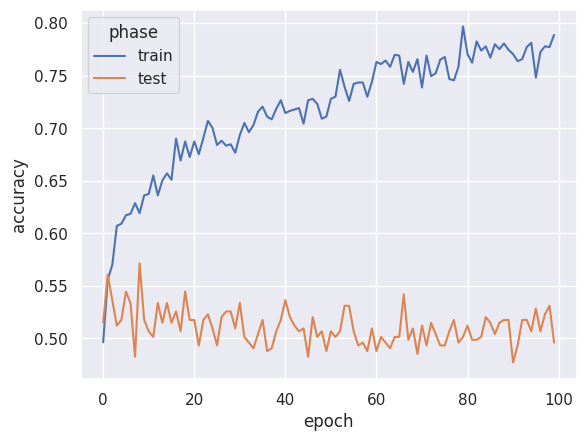

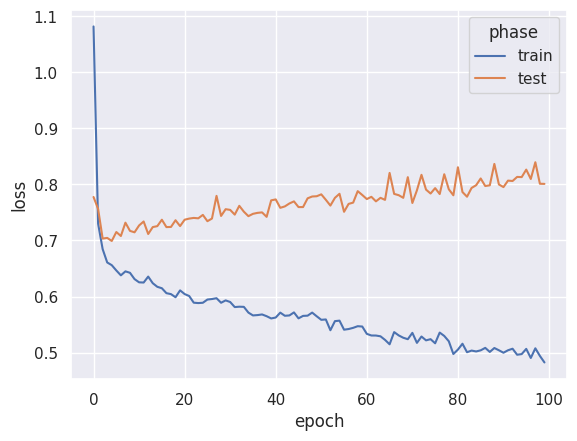

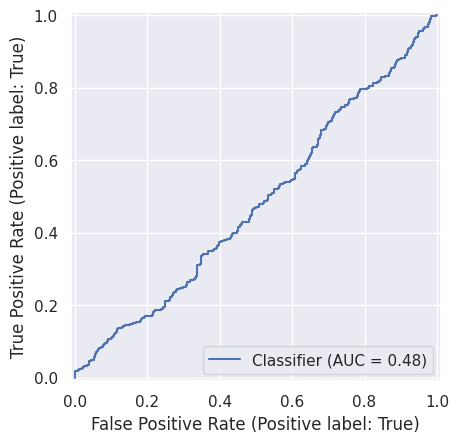

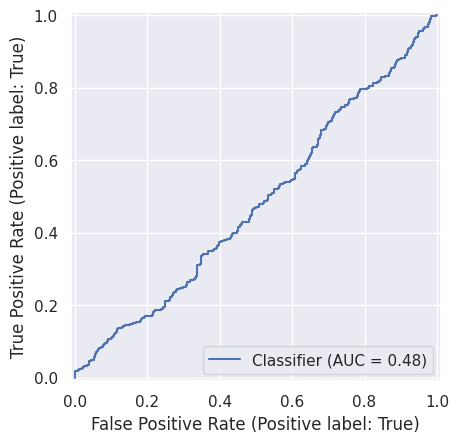

In [12]:
model_str = "mini"
train_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_train.tsv")
test_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_test.tsv")
val_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_val.tsv")
embeddings_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_div3_embeddings.tsv.gz")
output_prefix = Path("results/testing/sm7_500000_simple_pca")
checkpoint_path = Path("saved_models/sm7_500000_simple_pca")
batch_size = 128
epochs = 100
validation = True 
device = "cuda:0"


model_names = {"simple": simple_network,
               "small": small_network,
               "mini": mini_network}
if model_str in model_names:
    model = model_names[model_str]
else: raise ValueError(f"cannot find model with name {model_str}")

print("Making train loader")
train_loader = make_dataloaders(input_path=train_path, 
                                embeddings=embeddings_path, 
                                batch_size=batch_size)

print("Making test loader")
test_loader = make_dataloaders(input_path=test_path, 
                                embeddings=embeddings_path, 
                                batch_size=batch_size)

model, history = train_model(model, epochs, train_loader, test_loader, checkpoint_path=checkpoint_path, verbose=False, device=device)
plot_history(history, output_prefix)

model = model_names[model_str]

model = model().to("cuda:0")
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model.eval()

if validation:
    print("Making val loader")
    val_loader = make_dataloaders(input_path=val_path, embeddings=embeddings_path, batch_size=batch_size)
    pred, labels = run_validation(model, val_loader, device=device)
    plot_auc(pred, labels, output_prefix)

In [5]:
def reduce_size(df, max):
    return df[(df.seq_x.apply(len)<max) & (df.seq_y.apply(len)<max)]

train size: 1674
test size: 897
val size: 419
Making train loader
Making test loader
new high! 0.7452265322208405
Epoch: 0, train a/l: 0.518/0.873 test a/l: 0.495/0.745
new high! 0.7431640028953552
Epoch: 1, train a/l: 0.564/0.699 test a/l: 0.512/0.743
new high! 0.738738089799881
Epoch: 2, train a/l: 0.595/0.662 test a/l: 0.495/0.739
Epoch: 3, train a/l: 0.608/0.655 test a/l: 0.495/0.754
Epoch: 4, train a/l: 0.600/0.662 test a/l: 0.483/0.773
Epoch: 5, train a/l: 0.614/0.655 test a/l: 0.505/0.748
Epoch: 6, train a/l: 0.590/0.658 test a/l: 0.465/0.792
Epoch: 7, train a/l: 0.599/0.659 test a/l: 0.483/0.747
Epoch: 8, train a/l: 0.618/0.644 test a/l: 0.512/0.756
Epoch: 9, train a/l: 0.603/0.651 test a/l: 0.455/0.762
Epoch: 10, train a/l: 0.615/0.649 test a/l: 0.507/0.754
Epoch: 11, train a/l: 0.612/0.647 test a/l: 0.512/0.776
Epoch: 12, train a/l: 0.622/0.646 test a/l: 0.474/0.752
Epoch: 13, train a/l: 0.622/0.649 test a/l: 0.481/0.765
Epoch: 14, train a/l: 0.621/0.641 test a/l: 0.486/0.773

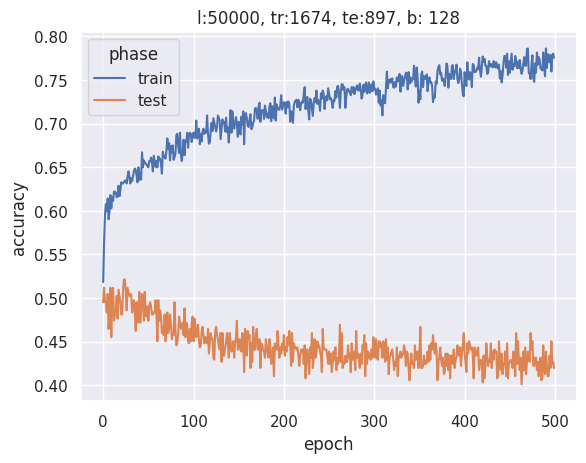

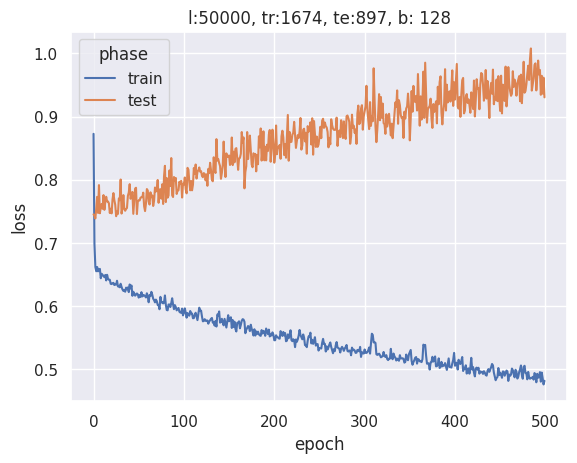

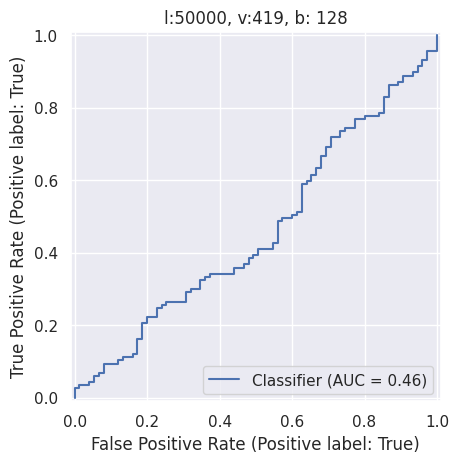

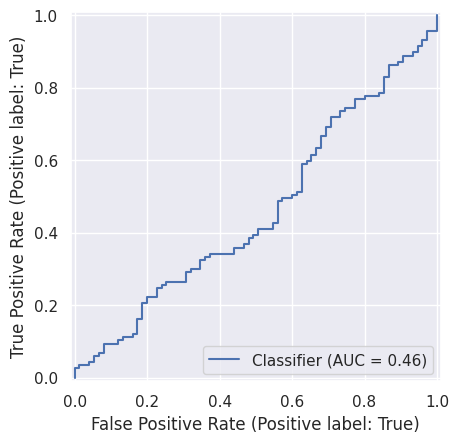

In [ ]:
train_seq_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_train_seq.tsv")
val_seq_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_test_seq.tsv")
test_seq_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_val_seq.tsv")

train_seq = pd.read_csv(train_seq_path, sep="\t", header=0, index_col=0)
test_seq = pd.read_csv(test_seq_path, sep="\t", header=0, index_col=0)
val_seq = pd.read_csv(val_seq_path, sep="\t", header=0, index_col=0)

model_str = "small"
embeddings_path = Path("data/aar_ath_bol_chi_cpa_tha/sm7_50000_div3_embeddings.tsv.gz")
# output_prefix = Path(f"results/comparing_sequence_length/sm7_500000_{model_str}_pca")
# checkpoint_path = Path(f"saved_models/comparing_sequence_length/sm7_500000_{model_str}_pca")
batch_size = 128
epochs = 500
validation = True
device = "cuda:0"
compression = True

model_names = {"simple": simple_network,
               "small": small_network,
               "mini": mini_network,
               "from_evo": from_evo}

# lengths = [50000, 40000, 30000, 20000, 10000, 8000]
lengths = [50000, 10000]

for max in lengths:

    train = reduce_size(train_seq, max)
    print(f"train size: {train.shape[0]}")
    test = reduce_size(test_seq, max)
    print(f"test size: {test.shape[0]}")
    val = reduce_size(val_seq, max)
    print(f"val size: {val.shape[0]}")


    output_prefix = Path(f"results/comparing_sequence_length/medium_2g_500_{max}_{model_str}_div3_{train.shape[0]}train")
    checkpoint_path = Path(f"saved_models/comparing_sequence_length/medium_2g_500_{max}_{model_str}_div3_{train.shape[0]}train")

    if model_str in model_names:
        model = model_names[model_str]
    else: raise ValueError(f"cannot find model with name {model_str}")

    print("Making train loader")
    train_loader = make_dataloaders(df=train, 
                                    embeddings=embeddings_path, 
                                    batch_size=batch_size, compression=compression)

    print("Making test loader")
    test_loader = make_dataloaders(df=test, 
                                    embeddings=embeddings_path, 
                                    batch_size=batch_size, compression=compression)

    model, history = train_model(model, epochs, train_loader, test_loader, checkpoint_path=checkpoint_path, verbose=False, device=device)
    plot_history(history, output_prefix, title=f"l:{max}, tr:{train.shape[0]}, te:{test.shape[0]}, b: {batch_size}")

    model = model_names[model_str]

    model = model().to(device)
    model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
    model.eval()

    if validation:
        print("Making val loader")
        val_loader = make_dataloaders(df= val, embeddings=embeddings_path, batch_size=batch_size, compression=compression)
        pred, labels = run_validation(model, val_loader, device=device)
        plot_auc(pred, labels, output_prefix, title=f"l:{max}, v:{val.shape[0]}, b: {batch_size}")